In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-data/489655
/kaggle/input/test-data/493673
/kaggle/input/react-net/pytorch/default/1/model_best.pth.tar


# Install Dependencies

In [2]:
!pip install torch torchvision numpy
!pip install pytorchcv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.2/134.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.2/585.2 kB 23.8 MB/s eta 0:00:00


# Import Relevant Libraries

In [3]:
import torch
import torchvision.models as models
import os
import zipfile
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import shutil
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Clone ReactNet Github Repo

In [4]:
!git clone https://github.com/liuzechun/ReActNet.git

Cloning into 'ReActNet'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 107 (delta 2), reused 0 (delta 0), pack-reused 100 (from 1)
Receiving objects: 100% (107/107), 28.45 KiB | 5.69 MiB/s, done.
Resolving deltas: 100% (35/35), done.


# Load the Pretrained React Mobile Net Model

In [42]:
# Path to the model file
model_path = '/kaggle/input/react-net/pytorch/default/1/model_best.pth.tar'

# Load the checkpoint file
checkpoint = torch.load(model_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')

# Inspect the checkpoint structure
print("Checkpoint keys:", checkpoint.keys())

/tmp/ipykernel_23/2626307578.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location='cuda' if torch.cuda.is_available() else 'c

Checkpoint keys: dict_keys(['epoch', 'state_dict', 'best_top1_acc', 'optimizer'])


In [43]:
# Load the MobileNetV2 architecture
model = models.mobilenet_v2(pretrained=False)

# Load the state_dict from the checkpoint
model_path = '/kaggle/input/react-net/pytorch/default/1/model_best.pth.tar'
checkpoint = torch.load(model_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')

# Load the model weights
model.load_state_dict(checkpoint['state_dict'], strict=False)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

print("Model loaded successfully!")

/tmp/ipykernel_23/2570102082.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location='cuda' if torch.cuda.is_available() else 'c

Model loaded successfully!


# Data Loading & Preprocessing

In [7]:
# Paths to zip files and extraction directories
train_zip_path = '/kaggle/input/train-data/489655'
test_zip_path = '/kaggle/input/test-data/493673'
train_extracted_path = './train-data'  # Destination for extracted train data
test_extracted_path = './test-data'    # Destination for extracted test data

# Function to unzip files and remove any __MACOSX folder
def unzip_data(zip_path, extract_to):
    print(f"Unzipping {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file in zip_ref.namelist():
            if not file.startswith('__MACOSX'):
                zip_ref.extract(file, extract_to)
    print(f"Extracted to {extract_to}")

    # Delete __MACOSX directory if it exists
    macosx_dir = os.path.join(extract_to, '__MACOSX')
    if os.path.exists(macosx_dir):
        shutil.rmtree(macosx_dir)
        print(f"Deleted {macosx_dir}")

# Unzip train and test datasets
if not os.path.exists(train_extracted_path):
    unzip_data(train_zip_path, train_extracted_path)
if not os.path.exists(test_extracted_path):
    unzip_data(test_zip_path, test_extracted_path)

# Correct root paths to point to 'real' and 'fake' subfolders
train_root = os.path.join(train_extracted_path, 'reduced_train')  # Target the reduced_train folder
test_root = os.path.join(test_extracted_path, 'reduced_test')     # Target the reduced_test folder

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for MobileNetV2
])

# Load full train dataset using ImageFolder
full_train_dataset = ImageFolder(root=train_root, transform=transform)

# Split the full_train_dataset into train (80%) and validation (20%)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Load test dataset
test_dataset = ImageFolder(root=test_root, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verify class names
print("Classes:", full_train_dataset.classes)
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

Unzipping /kaggle/input/train-data/489655...
Extracted to ./train-data
Unzipping /kaggle/input/test-data/493673...
Extracted to ./test-data
Classes: ['fake', 'real']
Number of training images: 8000
Number of validation images: 2000
Number of test images: 2000


# Modifying the Pretrained Model for Transfer Learning

In [44]:
import torch.nn as nn

# Modify the classifier head for 2 classes
num_classes = len(train_dataset.dataset.classes)  # Should be 2: 'fake' and 'real'
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training Loop

In [45]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to train and validate
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(train_loss / total_train)
        train_accuracies.append(correct_train / total_train)

        # Validation phase
        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_losses.append(val_loss / total_val)
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Number of Epochs - 5

Epoch 1/5: Train Loss: 0.7104, Train Acc: 0.5443 | Val Loss: 0.6926, Val Acc: 0.5295
Epoch 2/5: Train Loss: 0.6366, Train Acc: 0.6266 | Val Loss: 0.5998, Val Acc: 0.6585
Epoch 3/5: Train Loss: 0.5939, Train Acc: 0.6655 | Val Loss: 0.5731, Val Acc: 0.6780
Epoch 4/5: Train Loss: 0.5693, Train Acc: 0.6890 | Val Loss: 0.5703, Val Acc: 0.6730
Epoch 5/5: Train Loss: 0.5595, Train Acc: 0.6995 | Val Loss: 0.5458, Val Acc: 0.7080


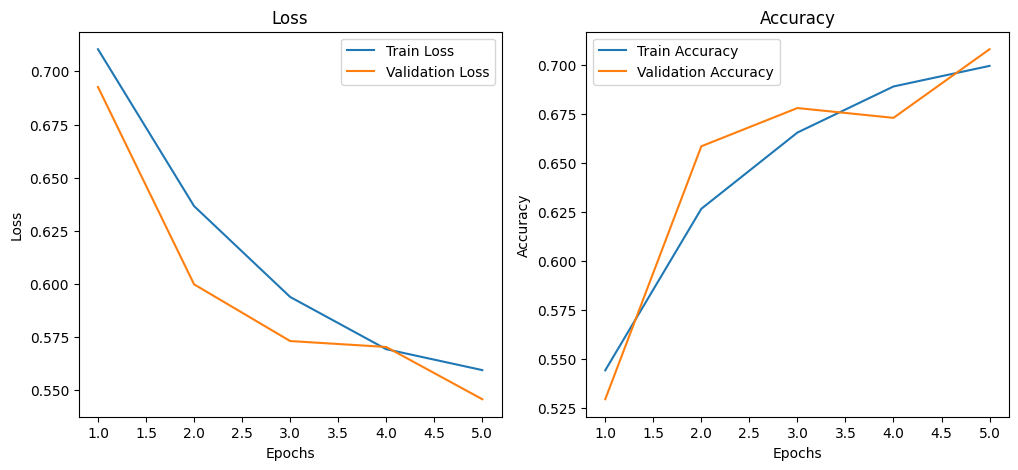

In [11]:
# Train the model
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs
)

# Plot Loss and Accuracy
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Number of Epochs - 15

Epoch 1/15: Train Loss: 0.7017, Train Acc: 0.5493 | Val Loss: 0.6502, Val Acc: 0.5295
Epoch 2/15: Train Loss: 0.6169, Train Acc: 0.6281 | Val Loss: 0.6074, Val Acc: 0.6345
Epoch 3/15: Train Loss: 0.5942, Train Acc: 0.6633 | Val Loss: 0.5784, Val Acc: 0.6700
Epoch 4/15: Train Loss: 0.5742, Train Acc: 0.6867 | Val Loss: 0.5723, Val Acc: 0.6825
Epoch 5/15: Train Loss: 0.5545, Train Acc: 0.7010 | Val Loss: 0.5446, Val Acc: 0.7135
Epoch 6/15: Train Loss: 0.5346, Train Acc: 0.7184 | Val Loss: 0.5483, Val Acc: 0.7095
Epoch 7/15: Train Loss: 0.5228, Train Acc: 0.7319 | Val Loss: 0.5538, Val Acc: 0.6960
Epoch 8/15: Train Loss: 0.5083, Train Acc: 0.7431 | Val Loss: 0.5555, Val Acc: 0.7065
Epoch 9/15: Train Loss: 0.4946, Train Acc: 0.7515 | Val Loss: 0.5666, Val Acc: 0.7125
Epoch 10/15: Train Loss: 0.4916, Train Acc: 0.7589 | Val Loss: 0.5250, Val Acc: 0.7335
Epoch 11/15: Train Loss: 0.4700, Train Acc: 0.7666 | Val Loss: 0.5185, Val Acc: 0.7290
Epoch 12/15: Train Loss: 0.4533, Train Acc: 0.7804 |

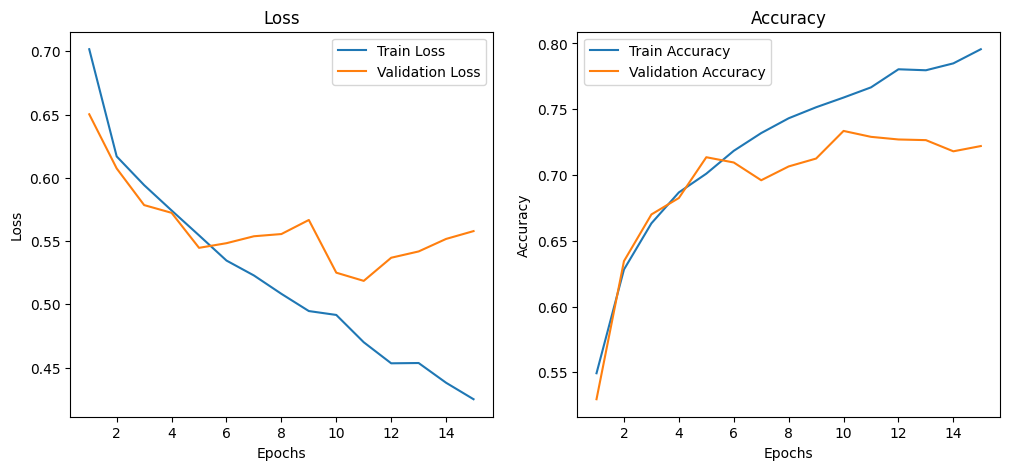

In [18]:
# Train the model
num_epochs = 15
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs
)

# Plot Loss and Accuracy
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Number of Epochs - 30

Epoch 1/30: Train Loss: 0.6884, Train Acc: 0.5621 | Val Loss: 0.6389, Val Acc: 0.6260
Epoch 2/30: Train Loss: 0.6331, Train Acc: 0.6149 | Val Loss: 0.5881, Val Acc: 0.6755
Epoch 3/30: Train Loss: 0.5897, Train Acc: 0.6613 | Val Loss: 0.5850, Val Acc: 0.6455
Epoch 4/30: Train Loss: 0.5652, Train Acc: 0.6936 | Val Loss: 0.5540, Val Acc: 0.6970
Epoch 5/30: Train Loss: 0.5499, Train Acc: 0.7096 | Val Loss: 0.5521, Val Acc: 0.7085
Epoch 6/30: Train Loss: 0.5396, Train Acc: 0.7159 | Val Loss: 0.5516, Val Acc: 0.7160
Epoch 7/30: Train Loss: 0.5179, Train Acc: 0.7365 | Val Loss: 0.5472, Val Acc: 0.7135
Epoch 8/30: Train Loss: 0.5072, Train Acc: 0.7421 | Val Loss: 0.5075, Val Acc: 0.7430
Epoch 9/30: Train Loss: 0.5000, Train Acc: 0.7456 | Val Loss: 0.5473, Val Acc: 0.7160
Epoch 10/30: Train Loss: 0.4900, Train Acc: 0.7579 | Val Loss: 0.5224, Val Acc: 0.7315
Epoch 11/30: Train Loss: 0.4769, Train Acc: 0.7626 | Val Loss: 0.5174, Val Acc: 0.7425
Epoch 12/30: Train Loss: 0.4499, Train Acc: 0.7762 |

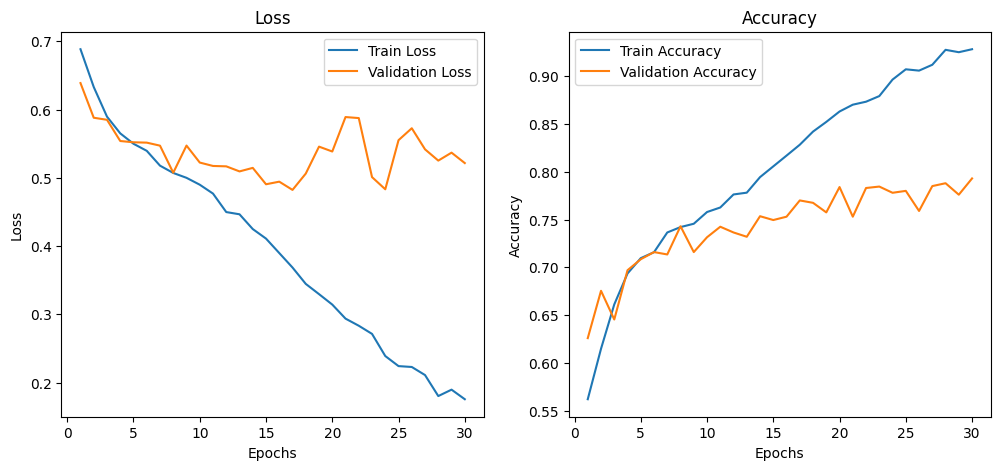

In [40]:
# Train the model
num_epochs = 30
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs
)

# Plot Loss and Accuracy
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Final Test Results - 30 Epochs

In [41]:
# --- Testing the Model ---
model.eval()
correct_test, total_test = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)

test_accuracy = (correct_test / total_test)*100
print(f"Test Accuracy: {test_accuracy:.4f}%")

Test Accuracy: 63.7000%


# Number of Epochs - 50

Epoch 1/50: Train Loss: 0.6901, Train Acc: 0.5451 | Val Loss: 0.6644, Val Acc: 0.5830
Epoch 2/50: Train Loss: 0.6228, Train Acc: 0.6232 | Val Loss: 0.6121, Val Acc: 0.6340
Epoch 3/50: Train Loss: 0.6005, Train Acc: 0.6587 | Val Loss: 0.5772, Val Acc: 0.6775
Epoch 4/50: Train Loss: 0.5714, Train Acc: 0.6834 | Val Loss: 0.5626, Val Acc: 0.6840
Epoch 5/50: Train Loss: 0.5555, Train Acc: 0.7054 | Val Loss: 0.5776, Val Acc: 0.6735
Epoch 6/50: Train Loss: 0.5383, Train Acc: 0.7140 | Val Loss: 0.5390, Val Acc: 0.7065
Epoch 7/50: Train Loss: 0.5166, Train Acc: 0.7376 | Val Loss: 0.5427, Val Acc: 0.7130
Epoch 8/50: Train Loss: 0.5093, Train Acc: 0.7396 | Val Loss: 0.5219, Val Acc: 0.7235
Epoch 9/50: Train Loss: 0.4908, Train Acc: 0.7534 | Val Loss: 0.5316, Val Acc: 0.7230
Epoch 10/50: Train Loss: 0.4879, Train Acc: 0.7521 | Val Loss: 0.5206, Val Acc: 0.7385
Epoch 11/50: Train Loss: 0.4689, Train Acc: 0.7714 | Val Loss: 0.4978, Val Acc: 0.7495
Epoch 12/50: Train Loss: 0.4529, Train Acc: 0.7794 |

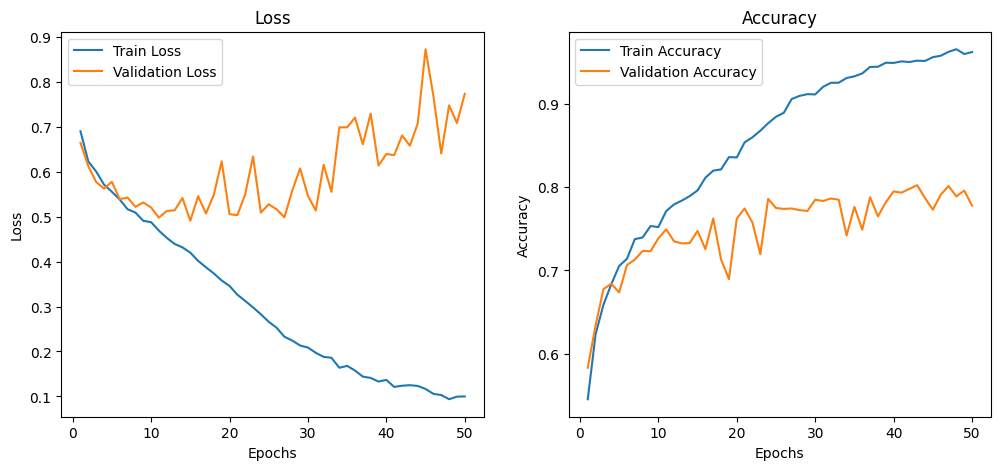

In [46]:
# Train the model
num_epochs = 50
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs
)

# Plot Loss and Accuracy
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Final Test Results - 50 Epochs

In [47]:
# --- Testing the Model ---
model.eval()
correct_test, total_test = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)

test_accuracy = (correct_test / total_test)*100
print(f"Test Accuracy: {test_accuracy:.4f}%")

Test Accuracy: 61.4500%


# Finetuned Hyperparameters

In [27]:
# Updated Optimizer with Weight Decay
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Updated Training Loop
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_loss = float('inf')
    patience = 5
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(train_loss / total_train)
        train_accuracies.append(correct_train / total_train)

        # Validation Phase
        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_losses.append(val_loss / total_val)
        val_accuracies.append(correct_val / total_val)

        # Learning Rate Scheduler Step
        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

        # Early Stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Stopping early at epoch {epoch+1}")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

# Number of Epochs - 50

Epoch 1/50: Train Loss: 0.6856, Train Acc: 0.5530 | Val Loss: 0.6561, Val Acc: 0.5930
Epoch 2/50: Train Loss: 0.6428, Train Acc: 0.6139 | Val Loss: 0.5981, Val Acc: 0.6475
Epoch 3/50: Train Loss: 0.5980, Train Acc: 0.6569 | Val Loss: 0.6427, Val Acc: 0.6330
Epoch 4/50: Train Loss: 0.5629, Train Acc: 0.6946 | Val Loss: 0.5958, Val Acc: 0.6585
Epoch 5/50: Train Loss: 0.5527, Train Acc: 0.7023 | Val Loss: 0.5645, Val Acc: 0.6890
Epoch 6/50: Train Loss: 0.5287, Train Acc: 0.7228 | Val Loss: 0.5797, Val Acc: 0.6785
Epoch 7/50: Train Loss: 0.5186, Train Acc: 0.7292 | Val Loss: 0.5928, Val Acc: 0.6795
Epoch 8/50: Train Loss: 0.5080, Train Acc: 0.7389 | Val Loss: 0.5479, Val Acc: 0.7120
Epoch 9/50: Train Loss: 0.4874, Train Acc: 0.7525 | Val Loss: 0.5757, Val Acc: 0.6885
Epoch 10/50: Train Loss: 0.4719, Train Acc: 0.7600 | Val Loss: 0.5454, Val Acc: 0.7140
Epoch 11/50: Train Loss: 0.4332, Train Acc: 0.7893 | Val Loss: 0.5492, Val Acc: 0.7160
Epoch 12/50: Train Loss: 0.4182, Train Acc: 0.7954 |

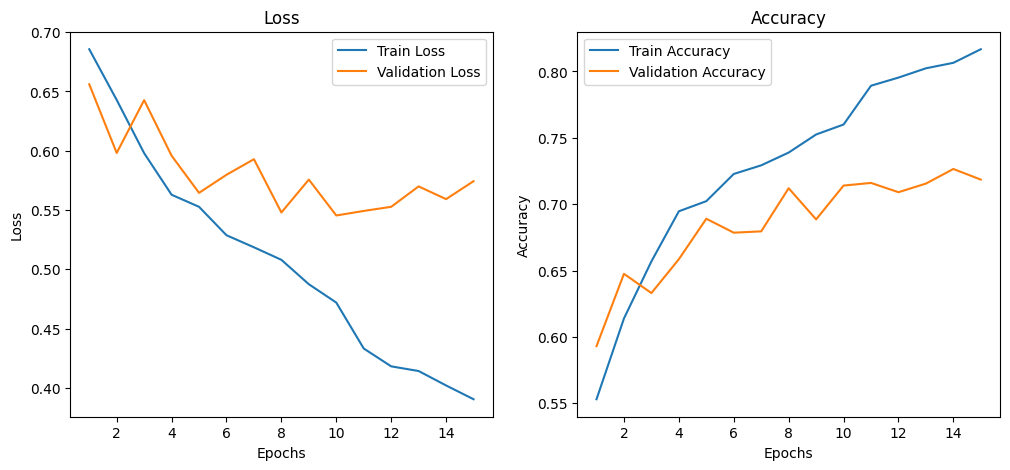

In [29]:
# Set the number of epochs
num_epochs = 50

# Call the training loop
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs
)

# Plot Loss and Accuracy
epochs = range(1, len(train_losses) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Final Test Results with Fine Tuned Hyperparameters

In [34]:
# --- Testing the Model ---
model.eval()
correct_test, total_test = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)

test_accuracy = (correct_test / total_test)*100
print(f"Test Accuracy: {test_accuracy:.4f}%")

Test Accuracy: 54.5000%
